In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
8555,14195,59147,Robinson Crusoe Island,20-03-2020,@Tesco #CoronaCrisis\r\r\nHEAD OFFICE......\r\...,Positive
12369,18797,63749,British,22-03-2020,@POTUS you must follw the Danish and British e...,Extremely Negative
30733,41602,86554,Dirty Old Detroit,11-04-2020,@GovWhitmer Massachusetts grocery/supermarke...,Extremely Positive
1826,6024,50976,Toronto,17-03-2020,"On my way home from the grocery store, I still...",Negative


**Задание 1 Подготовка**
Целевая переменная находится в колонке Sentiment. Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [3]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if 'Positive' in x else 0)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1


Сбалансированы ли классы?

In [4]:
classes_balance = df['Sentiment'].value_counts(normalize=True)
classes_balance

Sentiment
1    0.539589
0    0.460411
Name: proportion, dtype: float64

**Ответ:** Видим, что сильного перекоса в классах нет, данные хорошо сбалансированы.

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [5]:
no_data_info = df.isnull().sum()
no_data_info

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

Видим пропуски в Location

In [6]:
df['Location'].fillna('Unknown', inplace=True)
no_data_info = df.isnull().sum()
no_data_info

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и random_state=0

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)
train.shape, test.shape

((23410, 6), (10034, 6))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df['OriginalTweet'],
    df['Sentiment'],
    test_size=0.3,
    random_state=0
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23410,), (10034,), (23410,), (10034,))

**Задание 2 Токенизация**
Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр.

In [9]:
from collections import Counter

token = train['OriginalTweet'].str.lower().str.split().explode().tolist()
token_size = Counter(token)
len(token_size), token_size.most_common(10)

(79755,
 [('the', 26815),
  ('to', 23373),
  ('and', 14684),
  ('of', 13012),
  ('a', 11737),
  ('in', 11198),
  ('for', 8566),
  ('#coronavirus', 8223),
  ('is', 7383),
  ('are', 7050)])

  Размер словаря - 79755

  Причина популярности выведенных токенов - особенность английского языка, мы видим использование предлогов, союзов и тому подобных слов, кроме того, видим один хештэг, его поплурность тоже ясна - наши твиты посвещены теме короновируса.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности. Что можно сказать о нем?

In [10]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
filtered_token = {token: count for token, count in token_size.items() if token not in stop_words}
Counter(filtered_token).most_common(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[('#coronavirus', 8223),
 ('prices', 3891),
 ('food', 3820),
 ('grocery', 3469),
 ('supermarket', 3288),
 ('people', 3175),
 ('covid-19', 3173),
 ('store', 3155),
 ('#covid19', 2471),
 ('&amp;', 2314)]

После фильтрации стало ясно видно что больше всего волнует людей в сложившейся ситуации. Например явно можно сказать, что основные темы - супермаркеты, магазины, цены, еда.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [11]:
Counter(filtered_token).most_common()[-20:]

[('skellig', 1),
 ('coast!', 1),
 ('closer!)', 1),
 ('@skelligsix18', 1),
 ('#skelligcoast2kms', 1),
 ('#southkerry', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('premiership', 1),
 ('non-playing', 1),
 ('subsidise', 1),
 ('playersã\x82â\x92', 1),
 ('renewing', 1),
 ('wage!', 1),
 ('flew', 1),
 ('nothing...', 1),
 ('@torontopearson', 1),
 ('@680news', 1),
 ('https://t.co/7j2y3rsld9', 1)]

Непопулярность выведенных токенов ясна - это либо тег определенных пользователей, либо ссылки, либо слова с ошибками, или редко встречающиеся термины в языке. По сути они не несут никакой полезности в дальнейшем, по ним мы ничего не определим, поэтому их вполне можно удалить.

Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [12]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()
token_lists = train['OriginalTweet'].apply(tokenizer.tokenize)
all_tokens = [token for sublist in token_lists for token in sublist]
Counter(all_tokens).most_common(10)

[('the', 24337),
 ('.', 24118),
 ('to', 22933),
 (',', 17571),
 ('and', 14354),
 ('of', 12904),
 ('a', 11045),
 ('in', 10573),
 ('?', 9524),
 ('for', 8228)]

Кроме предлогов, союзов и артиклей, появились знаки припенании

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [13]:
from nltk.corpus import stopwords
from string import punctuation

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punctuation_set = set(punctuation)
filtered_tokens = {word: count for word, count in Counter(all_tokens).items() if word not in stop_words and word not in punctuation_set}
Counter(filtered_tokens).most_common(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('Â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('#coronavirus', 7143),
 ('I', 5235),
 ('\x92', 4372),
 ('prices', 4281),
 ('COVID', 4218),
 ('food', 3795),
 ('store', 3691)]

Слова появились, но и не слова тоже, например 'Â' или '\x82', это символы скорее всего из HTML, не несут никакой нужности.

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (ord(x) >= 128)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [14]:
unicode_tokens = {word: count for word, count in filtered_tokens.items() if len(word) > 1 and all(ord(char) < 128 for char in word)}
Counter(unicode_tokens).most_common(10)

[('19', 7167),
 ('#coronavirus', 7143),
 ('prices', 4281),
 ('COVID', 4218),
 ('food', 3795),
 ('store', 3691),
 ('supermarket', 3373),
 ('grocery', 3083),
 ('people', 3047),
 ('The', 2516)]

In [15]:
Counter(unicode_tokens).most_common()[-20:]

[('https://t.co/5cBLIqZX7L', 1),
 ('ruins', 1),
 ('now.When', 1),
 ('milion', 1),
 ('Skellig', 1),
 ('@SkelligSix18', 1),
 ('#SkelligCoast2kms', 1),
 ('#SouthKerry', 1),
 ('https://t.co/zJcL195VQS', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/IAEK4fWsgz', 1),
 ('Vile', 1),
 ('premiership', 1),
 ('non-playing', 1),
 ('subsidise', 1),
 ('renewing', 1),
 ('flew', 1),
 ('@TorontoPearson', 1),
 ('@680NEWS', 1),
 ('https://t.co/7j2Y3rSld9', 1)]

Как видим, теперь в топе нормальные слова. Теперь нет символов не несущих смысла, в топе самых редких слов все осталось примерно так же. Некоторые слова пропали на этапах фильтрации. В целом теперь стало гораздо чище, что должно улучшить точность модели в будущем.

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [16]:
hashtags = {word: count for word, count in Counter(unicode_tokens).items() if word.startswith('#')}
Counter(hashtags).most_common(10)

[('#coronavirus', 7143),
 ('#COVID19', 1844),
 ('#Covid_19', 1463),
 ('#Coronavirus', 1281),
 ('#COVID2019', 927),
 ('#toiletpaper', 657),
 ('#covid19', 568),
 ('#COVID', 542),
 ('#CoronaCrisis', 426),
 ('#CoronaVirus', 351)]

Все хэштеги посвещены теме короновируса и лишь один выделяется - '#toiletpaper', как мы помним так же наболевшая тема в момент пондемии.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [17]:
links = {word: count for word, count in Counter(unicode_tokens).items() if word.startswith('https://t.co')}
Counter(links).most_common(10)

[('https://t.co/oXA7SWtoNd', 5),
 ('https://t.co/gP3EusapL8', 4),
 ('https://t.co/WrLHYzIzAA', 3),
 ('https://t.co/kuwIpF1KQW', 3),
 ('https://t.co/zjNRx6dKKN', 3),
 ('https://t.co/3GBBDpdjat', 3),
 ('https://t.co/e2ZNXajPre', 3),
 ('https://t.co/CATKegAyOY', 3),
 ('https://t.co/G63RP042HO', 3),
 ('https://t.co/AZIqCdgrNn', 3)]

Упоминании ссылок очень мало, несравнимо мало по сравнению с хэштегами, информативной полезности не несут.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:

Привести текст в нижний регистр
Применить TweetTokenizer для изначального выделения токенов
Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co

In [18]:
def custom_tokenizer(text):
  text = text.lower()
  tknzr = TweetTokenizer()
  tokens = tknzr.tokenize(text)
  tokens = [
      token for token in tokens if token not in stop_words and
      token not in punctuation_set and
      len(token) > 1 and
      all(ord(char) < 128 for char in token) and
      not token.startswith('https://t.co')
  ]
  return tokens

custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

**Задание 3 Векторизация текстов (2 балла)**
Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
token = train['OriginalTweet']
cv.fit(token)
print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


44104


Разница колосальная, почти в два раза. До векторизации было 79755, после всех процедур - 44104.

Посмотрим на какой-нибудь конкретный твит:

In [20]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [21]:
tweet_text = train.iloc[ind]['OriginalTweet']
tweet_vector = cv.transform([tweet_text]).toarray()[0]

indices = [i for i, x in enumerate(tweet_vector) if x > 0]
values = tweet_vector[indices]

max_index = indices[values.argmax()]
min_index = indices[values.argmin()]

vocabulary = cv.get_feature_names_out()
important_token = vocabulary[max_index]
least_important_token = vocabulary[min_index]

important_token, least_important_token

('#coronavirusoutbreak', '#coronavirusoutbreak')

Получился интересный результат - самый важный и неважный токен один и тот же. Это связано с тем, что после всех процедур обработки у нас остался единственный ненулевой токен.

Теперь примените TfidfVectorizer и определите самый важный/неважный токены. Хорошо ли определились, почему?

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf.fit(train['OriginalTweet'].tolist())
tweet_tfidf_vector = tfidf.transform([tweet_text]).toarray()[0]
non_zero_indices_tfidf = [i for i, x in enumerate(tweet_tfidf_vector) if x > 0]

non_zero_values_tfidf = tweet_tfidf_vector[non_zero_indices_tfidf]
max_index_tfidf = non_zero_indices_tfidf[non_zero_values_tfidf.argmax()]
min_index_tfidf = non_zero_indices_tfidf[non_zero_values_tfidf.argmin()]
vocabulary_tfidf = tfidf.get_feature_names_out()
most_important_token_tfidf = vocabulary_tfidf[max_index_tfidf]
least_important_token_tfidf = vocabulary_tfidf[min_index_tfidf]
print(f"TfidfVectorizer - Most important: {most_important_token_tfidf}, Least important: {least_important_token_tfidf}")

TfidfVectorizer - Most important: brainless, Least important: food


Самое важное слово у нас получилось "brainless", оно несет в себе негативный окрас, по этому слову моделе проще всего понять окрас и на нем действительно стоить заострить внимание, тк по сарказму в начале предложения мы можем запутаться. Поэтому в целом все получилось хорошо.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

Подсказка: явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [23]:
positive_tweets = train[(train['OriginalTweet'].str.contains('amazing', case=False)) & (train['Sentiment'] == 1)]
positive_tweets

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4583,9362,54314,"Moulton, England",19-03-2020,Hearing so many stories of NHS heroes Teachers...,1
14710,21683,66635,"iPhone: 30.738749,-89.852348",23-03-2020,Amazing how some of the lowest paid people in ...,1
27471,37481,82433,"New York, NY",08-04-2020,Amazing and admirable work being done by all g...,1
8221,13787,58739,Unknown,20-03-2020,Let s just take a minute to say THANK YOU also...,1
3183,7654,52606,"London, England",18-03-2020,"Back at the ""Frontline""\r\r\nA massive shout o...",1
...,...,...,...,...,...,...
8199,13757,58709,Wrightington,20-03-2020,The support from customers this week has been ...,1
11636,17911,62863,Australia,21-03-2020,"Margot Robbie is an amazing actress, and love ...",1
23018,31918,76870,"Karachi, Pakistan",04-04-2020,Face Mask (Pack of 5) ÃÂ Meeting the need of...,1
5208,10126,55078,Unknown,19-03-2020,There's some amazing work going on in the worl...,1


In [24]:
tweet = positive_tweets.iloc[3]['OriginalTweet']

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english')
tfidf.fit(positive_tweets['OriginalTweet'].tolist())

tweet_tfidf = tfidf.transform([tweet]).toarray()[0]
indices = [i for i, x in enumerate(tweet_tfidf) if x > 0]

values = tweet_tfidf[indices]
max_index = indices[values.argmax()]
most_important_token = tfidf.get_feature_names_out()[max_index]

print(f"Tweet: {tweet}")
print(f"Most Important Token: {most_important_token}")

Tweet: Let s just take a minute to say THANK YOU also to the amazing postal workers So many real people behind a click of online shopping and getting cards delivered Thank   you   19
Most Important Token: thank


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


В этом примере писатель благодарит работников почты за работу во время ковида. TfidfVectorizer как наиболее важный токен выделил слово thank, что на самом деле очень хорошо для оценки окраски, вряд ли в твите с благодарением кого-либо будет негатив, только если в саракстической форме, но тут такого нет.

**Задание 4 Обучение первых моделей (1 балл)**


Примените оба векторайзера для получения матриц с признаками текстов. Выделите целевую переменную.

In [25]:
cv = CountVectorizer(tokenizer=custom_tokenizer)
tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)

train_texts = train['OriginalTweet'].values
train_labels = train['Sentiment'].values
test_texts = test['OriginalTweet'].values
test_labels = test['Sentiment'].values

train_counts = cv.fit_transform(train_texts)
test_counts = cv.transform(test_texts)

train_tfidf = tfidf.fit_transform(train_texts)
test_tfidf = tfidf.transform(test_texts)

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

cv_model = LogisticRegression(max_iter=200)
cv_model.fit(train_counts, train_labels)

tfidf_model = LogisticRegression(max_iter=200)
tfidf_model.fit(train_tfidf, train_labels)

train_pred_cv = cv_model.predict(train_counts)
test_pred_cv = cv_model.predict(test_counts)

train_pred_tfidf = tfidf_model.predict(train_tfidf)
test_pred_tfidf = tfidf_model.predict(test_tfidf)

train_acc_cv = accuracy_score(train_labels, train_pred_cv)
test_acc_cv = accuracy_score(test_labels, test_pred_cv)

train_acc_tfidf = accuracy_score(train_labels, train_pred_tfidf)
test_acc_tfidf = accuracy_score(test_labels, test_pred_tfidf)

(train_acc_cv, test_acc_cv), (train_acc_tfidf, test_acc_tfidf)

((0.9841093549765058, 0.8663543950568069),
 (0.9256727894062367, 0.8535977675901933))

В конкретно данном случае лучше себя показал CountVectorizer. Больше всего разница видна на train, но так или иначе, обе модели показывают хороший результат.

**Задание 5 Стемминг (0.5 балла)**
Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [28]:
from nltk.stem.snowball import SnowballStemmer
import string

def custom_stem_tokenizer(text):
    text = text.lower()
    tknzr = TweetTokenizer()
    stemmer = SnowballStemmer("english")
    tokens = tknzr.tokenize(text)
    stop_words = set(stopwords.words('english'))
    punctuation_set = set(string.punctuation)
    tokens = [
        stemmer.stem(token) for token in tokens if token not in stop_words and
        token not in punctuation_set and
        len(token) > 1 and
        all(ord(char) < 128 for char in token) and
        not token.startswith('https://t.co')
    ]
    return tokens

test_text = 'This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming'
custom_stem_tokenizer(test_text)

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [29]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv.fit(X_train)

tfidf = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tfidf.fit(X_train)

len(cv.vocabulary_), len(tfidf.vocabulary_)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(35451, 35451)

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [ ]:
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

lr_cv = LogisticRegression(max_iter=200)
lr_cv.fit(X_train_cv, y_train)

lr_tfidf = LogisticRegression(max_iter=200)
lr_tfidf.fit(X_train_tfidf, y_train)

y_pred_cv = lr_cv.predict(X_test_cv)
y_pred_cv_train = lr_cv.predict(X_train_cv)

y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)
y_pred_tfidf_train = lr_tfidf.predict(X_train_tfidf)

acc_cv_test = accuracy_score(y_test, y_pred_cv)
acc_cv_train = accuracy_score(y_train, y_pred_cv_train)

acc_tfidf_test = accuracy_score(y_test, y_pred_tfidf)
acc_tfidf_train = accuracy_score(y_train, y_pred_tfidf_train)

(acc_cv_train, acc_cv_test), (acc_tfidf_train, acc_tfidf_test)

((0.9705254164886801, 0.8668527008172214),
 (0.9154634771465185, 0.8549930237193542))

Теперь сравним.

  Без стемминга:
  ((0.9841093549765058, 0.8663543950568069),

  (0.9256727894062367, 0.8535977675901933))

  С стемингом:
  ((0.9705254164886801, 0.8668527008172214),

  (0.9154634771465185, 0.8549930237193542))

На train видим незначительное ухудшение, зато на test улучшение, но тоже маленькое. Особого смысла его применять в данном случае нет, улучшения минимальный.

**Задание 6 Работа с частотами (1.5 балла)**

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.

Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [32]:
max_df = 0.98
st = -0.01
while True:
    cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                            max_df=max_df).fit(X_train)
    if len(cv_df.vocabulary_) <= 35450:
        break
    max_df += st
    print(max_df)

len(cv_df.vocabulary_), max_df

0.97
0.96
0.95
0.94
0.9299999999999999
0.9199999999999999
0.9099999999999999
0.8999999999999999
0.8899999999999999
0.8799999999999999
0.8699999999999999
0.8599999999999999
0.8499999999999999
0.8399999999999999
0.8299999999999998
0.8199999999999998
0.8099999999999998
0.7999999999999998
0.7899999999999998
0.7799999999999998
0.7699999999999998
0.7599999999999998
0.7499999999999998
0.7399999999999998
0.7299999999999998
0.7199999999999998
0.7099999999999997
0.6999999999999997
0.6899999999999997
0.6799999999999997
0.6699999999999997
0.6599999999999997
0.6499999999999997
0.6399999999999997
0.6299999999999997
0.6199999999999997
0.6099999999999997
0.5999999999999996
0.5899999999999996
0.5799999999999996
0.5699999999999996
0.5599999999999996
0.5499999999999996
0.5399999999999996
0.5299999999999996
0.5199999999999996
0.5099999999999996
0.49999999999999956
0.48999999999999955
0.47999999999999954
0.46999999999999953
0.4599999999999995
0.4499999999999995
0.4399999999999995
0.4299999999999995
0.41999

(35450, 0.36999999999999944)

Объем словаря получается 35450, при попытках найстройки вручную особого результата нет. Предпологаю, что для получения нужного результата необходим автомотизированный подбор шага, например с помощью бинарного поиска.

max_df по итогу получился 0.37, значит, что каждое слово, которое встречается в датасете текстов с вероятностью более 37%, будет исключено. В целом коэф. получился стандартным, не наблюдаю крупных перекосов.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [36]:
min_df = 0.0005
st = -0.00005

while True:
    cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                            min_df=min_df).fit(X_train)
    print(min_df, len(cv_df.vocabulary_))
    if len(cv_df.vocabulary_) > 3699:
        break
    min_df += st

len(cv_df.vocabulary_), min_df

0.0005 3421
0.00045 3629
0.00039999999999999996 3859


(3859, 0.00039999999999999996)

Получили результат 3859 - размер словаря, 0.0004 порог встречаемости слова, чтобы добавить его в словарь. Глобально мало что удалось поменять, мы исключили очень малую часть. Возможно как и в прошлом задании необходимо точечная автомотическая настройка шага.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите berplot содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


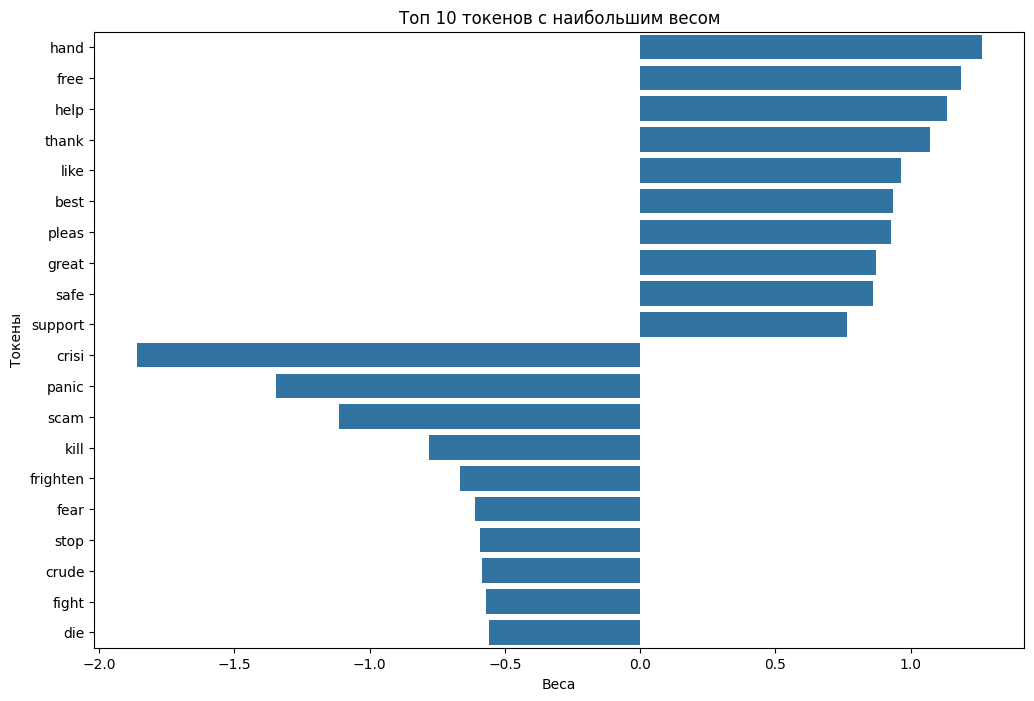

(0.9449807774455361,
 0.846820809248555,
 ['hand',
  'free',
  'help',
  'thank',
  'like',
  'best',
  'pleas',
  'great',
  'safe',
  'support'],
 ['crisi',
  'panic',
  'scam',
  'kill',
  'frighten',
  'fear',
  'stop',
  'crude',
  'fight',
  'die'])

In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

cv_min= CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=0.00039).fit(X_train)
train_cv_min = cv_min.transform(X_train)
test_cv_min = cv_min.transform(X_test)

pl = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=200))
pl.fit(train_cv_min, y_train)

y_train_pred_scaled = pl.predict(train_cv_min)
y_test_pred_scaled = pl.predict(test_cv_min)
train_accuracy = accuracy_score(y_train, y_train_pred_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred_scaled)

weights = pl.named_steps['logisticregression'].coef_[0]
positive_tokens = [token for token, weight in sorted(zip(cv_min.get_feature_names_out(), weights), key=lambda x: x[1], reverse=True)[:10]]
negative_tokens = [token for token, weight in sorted(zip(cv_min.get_feature_names_out(), weights), key=lambda x: x[1])[:10]]

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=[weight for token, weight in sorted(zip(cv_min.get_feature_names_out(), weights), key=lambda x: x[1], reverse=True)[:10] + sorted(zip(cv_min.get_feature_names_out(), weights), key=lambda x: x[1])[:10]],
            y=[token for token, weight in sorted(zip(cv_min.get_feature_names_out(), weights), key=lambda x: x[1], reverse=True)[:10] + sorted(zip(cv_min.get_feature_names_out(), weights), key=lambda x: x[1])[:10]], orient='h')
ax.set_title('Топ 10 токенов с наибольшим весом')
ax.set_xlabel('Веса')
ax.set_ylabel('Токены')
plt.show()

train_accuracy, test_accuracy, positive_tokens, negative_tokens

В полученном списке позитивных токенов слова по типу help, great, safe, support, значит мы сделали все верно, данные слова действительно эмоцинольно - положительные.

В негативных слова по типу crisi, panic, kill, fear. Тут тоже все правильно, слова действительно с негативчиком.

**Задание 7 Другие признаки (1.5 балла)**

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [55]:
from scipy.sparse import hstack
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import MaxAbsScaler

hasher = FeatureHasher(n_features=20, input_type='string')

X_train, X_test, y_train, y_test = train_test_split(df['OriginalTweet'], df['Sentiment'], test_size=0.3, random_state=52)

cv = CountVectorizer(min_df=0.00039, max_df = 0.369)
X_train_text = cv.fit_transform(X_train)
X_test_text = cv.transform(X_test)

X_train_user = hasher.transform(df.loc[X_train.index, 'UserName'].apply(lambda x: [str(x)]))
X_test_user = hasher.transform(df.loc[X_test.index, 'UserName'].apply(lambda x: [str(x)]))
X_train_screen = hasher.transform(df.loc[X_train.index, 'ScreenName'].apply(lambda x: [str(x)]))
X_test_screen = hasher.transform(df.loc[X_test.index, 'ScreenName'].apply(lambda x: [str(x)]))

X_train = hstack([X_train_text, X_train_user, X_train_screen])
X_test = hstack([X_test_text, X_test_user, X_test_screen])

scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=200)
model.fit(X_train_scaled, y_train)

train_pred = model.predict(X_train_scaled)
y_pred = model.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, train_pred)
print("Точность с дополнительными признаками:", accuracy_train, accuracy_test)

Точность с дополнительными признаками: 0.9351131994873986 0.8630655770380705


По результатам видим, что глобальных улучшении в точности нет. На предыдущих шагах были модели поточнее.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

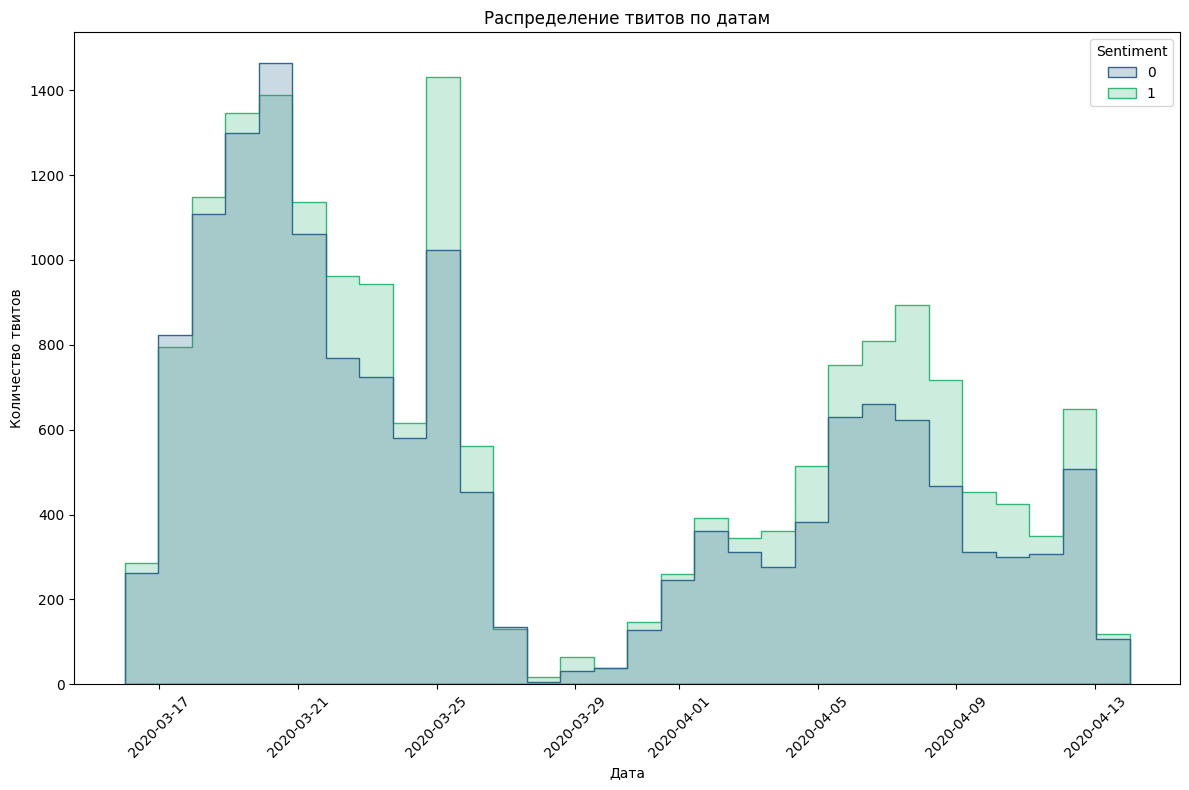

In [57]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='TweetAt', hue='Sentiment', element='step', palette='viridis', bins=30)
plt.title('Распределение твитов по датам')
plt.xlabel('Дата')
plt.ylabel('Количество твитов')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [62]:
df['day_of_week'] = df['TweetAt'].dt.dayofweek
df['hour'] = df['TweetAt'].dt.hour

X_train, X_test, y_train, y_test = train_test_split(df[['OriginalTweet', 'day_of_week', 'hour']], df['Sentiment'], test_size=0.3, random_state=52)

cv = CountVectorizer(min_df=0.00039, max_df = 0.369)
X_train_text = cv.fit_transform(X_train['OriginalTweet'])
X_test_text = cv.transform(X_test['OriginalTweet'])

scaler = StandardScaler(with_mean=False)
X_train_temporal = scaler.fit_transform(X_train[['day_of_week', 'hour']])
X_test_temporal = scaler.transform(X_test[['day_of_week', 'hour']])

X_train = hstack([X_train_text, X_train_temporal])
X_test = hstack([X_test_text, X_test_temporal])

model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)


train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, train_pred)
print("Точность модели с признаками даты и времени:", accuracy_train, accuracy_test)

Точность модели с признаками даты и времени: 0.9460059803502776 0.8712377915088698


Видим небольшое улучшение по сравнению с предыдущей моделью, полезность есть, но незначительная.

Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [64]:
locations = df['Location'].nunique()
print("Количество уникальных значений в столбце 'Location':", locations)

Количество уникальных значений в столбце 'Location': 10465


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

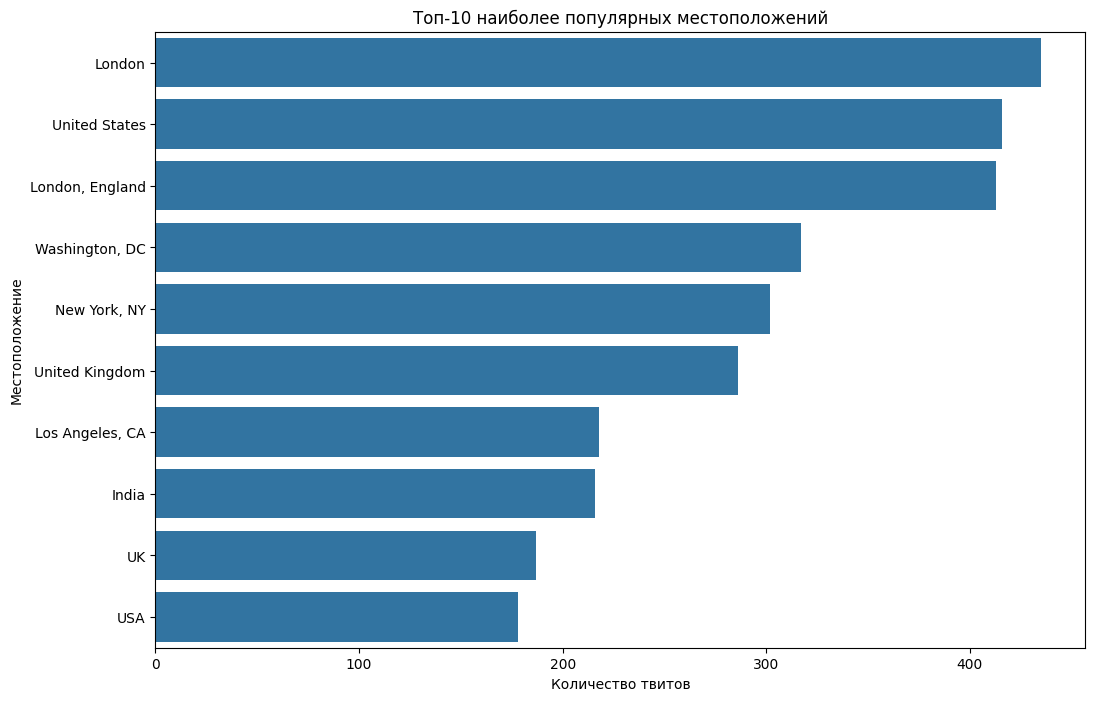

In [66]:
filtered_df = df[df['Location'] != 'Unknown']

location_counts = filtered_df['Location'].value_counts().head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=location_counts.values, y=location_counts.index)
plt.title('Топ-10 наиболее популярных местоположений')
plt.xlabel('Количество твитов')
plt.ylabel('Местоположение')
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

<ipython-input-73-d6f1bea45d00>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['WiderLocation'] = filtered_df['Location'].apply(wider_location)
<ipython-input-73-d6f1bea45d00>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['StandardizedLocation'] = filtered_df['WiderLocation'].replace(location)


Количество уникальных 'широких' местоположений: 6117


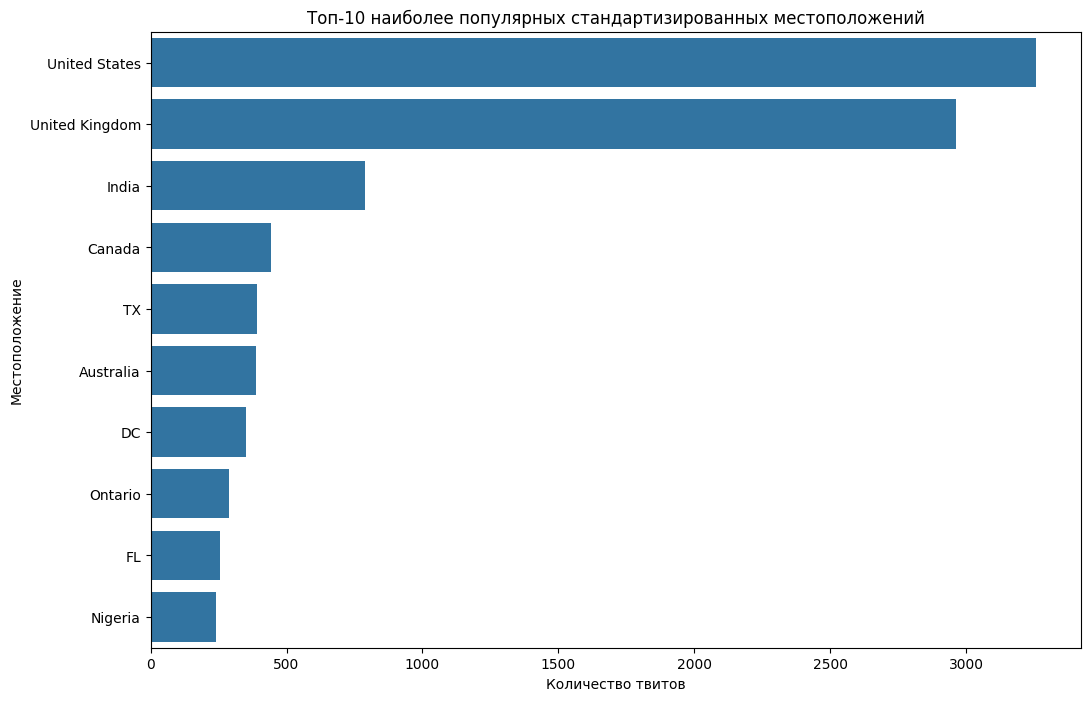

In [73]:
def wider_location(location):
    parts = location.split(',')
    if len(parts) > 1:
        return parts[-1].strip()
    return location.strip()

filtered_df['WiderLocation'] = filtered_df['Location'].apply(wider_location)

location = {
    'USA': 'United States',
    'United States': 'United States',
    'NY': 'United States',
    'CA': 'United States',
    'England': 'United Kingdom',
    'London': 'United Kingdom',
    'UK': 'United Kingdom',
    'United Kingdom': 'United Kingdom'
}
filtered_df['StandardizedLocation'] = filtered_df['WiderLocation'].replace(location)
unique_standardized_locations = filtered_df['StandardizedLocation'].nunique()
print("Количество уникальных 'широких' местоположений:", wider_locations)

standardized_location_counts = filtered_df['StandardizedLocation'].value_counts().head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=standardized_location_counts.values, y=standardized_location_counts.index)
plt.title('Топ-10 наиболее популярных стандартизированных местоположений')
plt.xlabel('Количество твитов')
plt.ylabel('Местоположение')
plt.show()

Теперь гораздо лучше, видим что подавляющее большинство твитов с Англии и Америки.

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?

In [78]:
from sklearn.preprocessing import OneHotEncoder

location_counts = filtered_df['StandardizedLocation'].value_counts()
locations_more_than_once = location_counts[location_counts > 1].index
filtered_df = filtered_df[filtered_df['StandardizedLocation'].isin(locations_more_than_once)]

encoder = OneHotEncoder(sparse=False)
encoded_locations = encoder.fit_transform(filtered_df[['StandardizedLocation']])

encoded_df = pd.DataFrame(encoded_locations, columns=encoder.get_feature_names_out())

print("Количество столбцов для местоположений, которые встречаются более одного раза:", encoded_df.shape[1])

Количество столбцов для местоположений, которые встречаются более одного раза: 1301


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?

Подсказка: используйте параметр categories в энкодере.

In [83]:
vectorizer = CountVectorizer(min_df=0.00039, max_df = 0.369)
X_text = vectorizer.fit_transform(filtered_df['OriginalTweet'])

scaler = MaxAbsScaler()
X_text_scaled = scaler.fit_transform(X_text)

categories = filtered_df['StandardizedLocation'].value_counts()[filtered_df['StandardizedLocation'].value_counts() > 1].index.tolist()

encoder = OneHotEncoder(categories=[categories], sparse=False)
encoded_locations = encoder.fit_transform(filtered_df[['StandardizedLocation']])

X_combined = hstack([X_text_scaled, encoded_locations])

y = filtered_df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)


train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, train_pred)
print("Точность модели:", accuracy_train, accuracy_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Точность модели: 0.9532005030780433 0.8514285714285714


Все так же глобальных улучшении нет. Немного увеличилась точность на train, и снизилась на test.